### Load modules

In [6]:
import pandas as pd
import numpy as np
import os, re 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

#helper function for parsing the names later on
def parse_data(data):
    parsed_data = {}
    current_section = None
    for line in data.splitlines():
        # Check if the line starts a new section
        section_match = re.match(section_regex, line)
        if section_match:
            current_section = section_match.group().strip(':')
            parsed_data[current_section] = []
        elif current_section:  # Add billboard data to the current section
            billboards = re.findall(billboard_regex, line)
            if billboards:
                parsed_data[current_section].extend(billboards)
    return parsed_data

# Regular expressions to identify the different sections
section_regex = r"(Participant ID:\s\w+|passed_billboard_index_list:|passed_fixated_first_list:|passed_fixated_incepted_list:|repeated_forgone_list:|forgone_list:|passed_list:|glanced_list:)"
billboard_regex = r"billboard_image_\d+"

#### Setting up subjects and result data frame

In [7]:
sub_list = [f'sub{str(i).zfill(3)}' for i in range(1, 40)]
n_subs = len(sub_list)
print(sub_list[:3])

result_df = pd.DataFrame(np.zeros((n_subs, 9)), columns = ['subj', 'condition',
                                                          'recall_passed_fixated_first', 'recall_fixated_incepted', 'recall_repeated_forgone', 'recall_forgone',
                                                          'recognition_passed_fixated_first', 'recognition_fixated_incepted', 'recognition_repeated_forgone', 'recognition_forgone',])

result_df['subj'] = sub_list
result_df.head(3)

['sub001', 'sub002', 'sub003']


,subj,recall_passed_fixated_first,recall_fixated_incepted,recall_repeated_forgone,recall_forgone,recognition_passed_fixated_first,recognition_fixated_incepted,recognition_repeated_forgone,recognition_forgone
0,sub001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sub002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sub003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Major loop around subjects

In [39]:
for current_subject in sub_list:
    print(current_subject)

    #### Set up the file names to be read for this subject
    position_names_file        = '../data/01_gaze_data/' + current_subject + '_billboard_list_position_name_assignment.csv'
    passing_viewing_list_file  = '../data/01_gaze_data/' + current_subject + '_lists_1.txt'
    recall_file                = '../data/03_interview_qualtrics_data/recall_sheet.csv'
    recognition_file           = '../data/03_interview_qualtrics_data/recognition_sheet.csv'

    #######################################################################################
    
    #### Reading the position_name file
    #### this gives us the "raw names" of which billboards were for this ppt at which position, which will be used to relabel the output files.
    df_position_names  = pd.read_csv(position_names_file)
    df_position_names['billboard_name_at_position_cleaned'] = df_position_names['billboard_image_at_position'].apply(lambda x: x.replace("resources/billboards/", "").replace(".bmp", ""))
    df_dropped = df_position_names.drop(['index', 'position_index', 'billboard_image_at_position'], axis=1)
    mapping_dict = pd.Series(df_dropped['billboard_name_at_position_cleaned'].values, index=df_dropped['billboard_named_position']).to_dict()

    #######################################################################################
    
    #### Reading the file with the remembered billboards
    #### This gives us the behavioral information, i.e. which bbs were looked at, not looked at, incepted, etc.
    with open(passing_viewing_list_file, 'r', encoding='utf-8') as file:
        data = file.read()
    parsed_data = parse_data(data)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in parsed_data.items()])) # Convert to a DataFrame (optional)
    
    passed_fixated_first_list = df['passed_fixated_first_list'].dropna()
    passed_fixated_first_list = list(passed_fixated_first_list.values)
    passed_fixated_first_list = [mapping_dict.get(item, item) for item in passed_fixated_first_list]
    
    passed_fixated_incepted_list = df['passed_fixated_incepted_list'].dropna()
    passed_fixated_incepted_list = list(passed_fixated_incepted_list.values)
    passed_fixated_incepted_list = [mapping_dict.get(item, item) for item in passed_fixated_incepted_list]
    
    repeated_forgone_list = df['repeated_forgone_list'].dropna()
    repeated_forgone_list = list(repeated_forgone_list.values)
    repeated_forgone_list = [mapping_dict.get(item, item) for item in repeated_forgone_list]
    
    forgone_list = df['forgone_list'].dropna()
    forgone_list = list(forgone_list.values)
    forgone_list = [mapping_dict.get(item, item) for item in forgone_list]
    
    passed_list = df['passed_list'].dropna()
    passed_list = list(passed_list.values)
    passed_list = [mapping_dict.get(item, item) for item in passed_list]
    
    glanced_list = df['glanced_list'].dropna()
    glanced_list = list(glanced_list.values)
    glanced_list = [mapping_dict.get(item, item) for item in glanced_list]

    #######################################################################################

    #### Reading the recall data file
    #### this gives us this participant's memory
    recall_df = pd.read_csv(recall_file)
    this_sub_df = recall_df[recall_df['subject'] == current_subject]
    this_sub_recalled = this_sub_df.columns[this_sub_df.iloc[0] == 1].tolist()
    #print(this_sub_recalled)

   #######################################################################################

    #### Combining the viewing lists with the recalls and compute memory results for each cell
    # passed_fixated_first_list: determine which items from the recall_list where in the passed_fixated_first_list
    common_elements = [item for item in passed_fixated_first_list if item in this_sub_recalled]
    recall_passed_fixated_first = len(common_elements)/len(passed_fixated_first_list) if len(passed_fixated_first_list) != 0 else 0
    
    # passed_fixated_incepted_list: determine which items from the recall_list where in the passed_fixated_incepted_list
    common_elements = [item for item in passed_fixated_incepted_list if item in this_sub_recalled]
    recall_fixated_incepted = len(common_elements)/len(passed_fixated_incepted_list) if len(passed_fixated_incepted_list) != 0 else 0
    
    # repeated_forgone_list: determine which items from the recall_list where in the repeated_forgone_list
    common_elements = [item for item in repeated_forgone_list if item in this_sub_recalled] 
    recall_repeated_forgone = len(common_elements)/len(repeated_forgone_list) if len(repeated_forgone_list) != 0 else 0
        
    # forgone_list: determine which items from the recall_list where in the forgone_list
    common_elements = [item for item in forgone_list if item in this_sub_recalled] 
    recall_forgone = len(common_elements)/len(forgone_list) if len(forgone_list) != 0 else 0
    
    result_df.loc[result_df['subj'] == current_subject, 'recall_passed_fixated_first'] = recall_passed_fixated_first
    result_df.loc[result_df['subj'] == current_subject, 'recall_fixated_incepted']     = recall_fixated_incepted
    result_df.loc[result_df['subj'] == current_subject, 'recall_repeated_forgone']     = recall_repeated_forgone
    result_df.loc[result_df['subj'] == current_subject, 'recall_forgone']              = recall_forgone
    result_df.loc[result_df['subj'] == current_subject, 'condition']                   = this_sub_df['condition'].values[0]

   #######################################################################################

    #### Reading the Recognition Data
    recognition_df = pd.read_csv(recognition_file)
    this_sub_df = recognition_df[recognition_df['subject'] == current_subject]
    this_sub_recognized = this_sub_df.columns[this_sub_df.iloc[0] == 1].tolist()
    #print(this_sub_recognized)

   #######################################################################################

    # passed_fixated_first_list: determine which items from the recall_list where in the passed_fixated_first_list
    common_elements = [item for item in passed_fixated_first_list if item in this_sub_recognized]
    recognition_passed_fixated_first = len(common_elements)/len(passed_fixated_first_list) if len(passed_fixated_first_list) != 0 else 0
    
    # passed_fixated_incepted_list: determine which items from the recall_list where in the passed_fixated_incepted_list
    common_elements = [item for item in passed_fixated_incepted_list if item in this_sub_recognized]
    recognition_fixated_incepted = len(common_elements)/len(passed_fixated_incepted_list) if len(passed_fixated_incepted_list) != 0 else 0
    
    # repeated_forgone_list: determine which items from the recall_list where in the repeated_forgone_list
    common_elements = [item for item in repeated_forgone_list if item in this_sub_recognized] 
    recognition_repeated_forgone = len(common_elements)/len(repeated_forgone_list) if len(repeated_forgone_list) != 0 else 0

    # forgone_list: determine which items from the recall_list where in the forgone_list
    common_elements = [item for item in forgone_list if item in this_sub_recognized] 
    recognition_forgone = len(common_elements)/len(forgone_list) if len(forgone_list) != 0 else 0

    result_df.loc[result_df['subj'] == current_subject, 'recognition_passed_fixated_first'] = recognition_passed_fixated_first
    result_df.loc[result_df['subj'] == current_subject, 'recognition_fixated_incepted']     = recognition_fixated_incepted
    result_df.loc[result_df['subj'] == current_subject, 'recognition_repeated_forgone']     = recognition_repeated_forgone
    result_df.loc[result_df['subj'] == current_subject, 'recognition_forgone']              = recognition_forgone

print('Done')

sub001
sub002
sub003
sub004
sub005
sub006
sub007
sub008
sub009
sub010
sub011
sub012
sub013
sub014
sub015
sub016
sub017
sub018
sub019
sub020
sub021
sub022
sub023
sub024
sub025
sub026
sub027
sub028
sub029
sub030
sub031
sub032
sub033
sub034
sub035
sub036
sub037
sub038
sub039
Done


In [40]:
result_df.head()
result_df.to_csv('../data/04_statistics/core_recall_recognition_results.csv')

### Plot Recall 

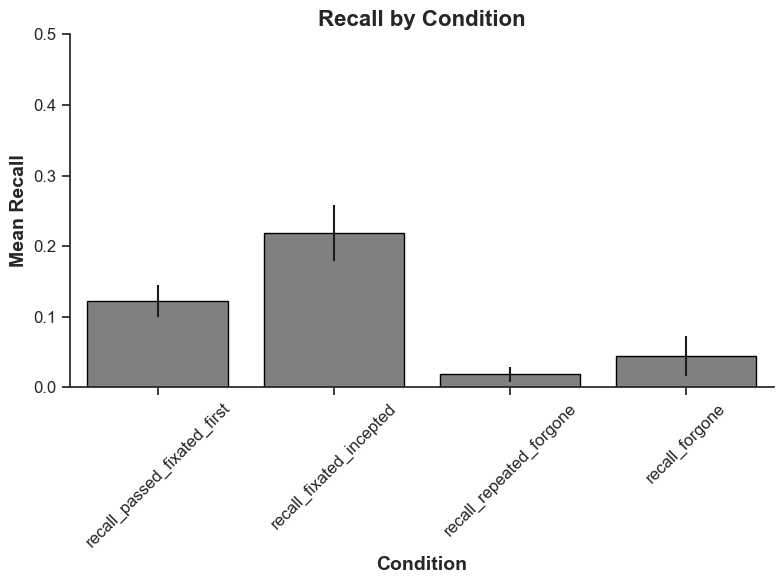

In [33]:
# Select columns to plot
columns_to_plot = ['recall_passed_fixated_first', 'recall_fixated_incepted', 'recall_repeated_forgone', 'recall_forgone']

# Calculate means and standard errors (or standard deviations)
means = result_df[columns_to_plot].mean()
errors = result_df[columns_to_plot].sem()  # Use .std() for standard deviation if preferred

plt.figure(figsize=(8, 6))

# Create bar plot
ax = sns.barplot(
    x=means.index, 
    y=means.values, 
    yerr=errors.values, 
    capsize=0.1, 
    color="grey", 
    edgecolor="black")

# Customize plot appearance
ax.set_xlabel("Condition", fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
ax.set_ylabel("Mean Recall", fontsize=14, weight='bold')
ax.set_ylim([0, 0.5])
ax.set_title("Recall by Condition", fontsize=16, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

### Plot Recognition

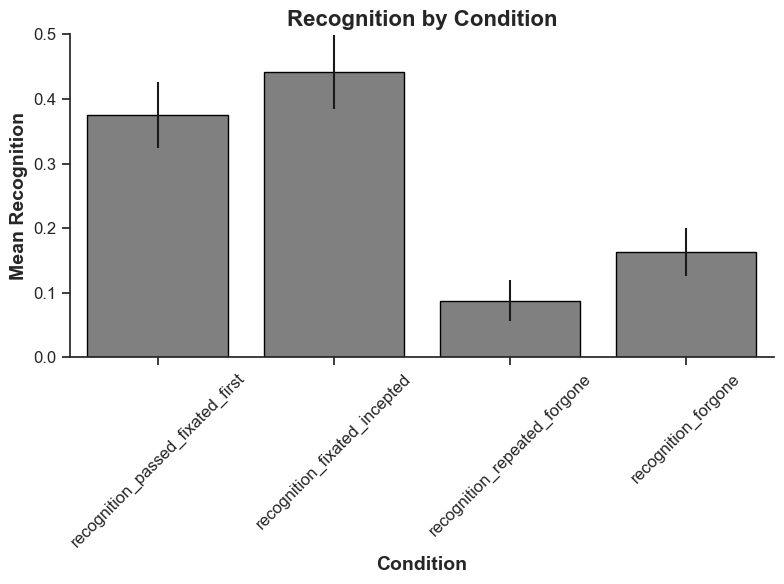

In [34]:
# Select columns to plot
columns_to_plot = ['recognition_passed_fixated_first', 'recognition_fixated_incepted', 'recognition_repeated_forgone', 'recognition_forgone']

# Calculate means and standard errors (or standard deviations)
means = result_df[columns_to_plot].mean()
errors = result_df[columns_to_plot].sem()  # Use .std() for standard deviation if preferred

plt.figure(figsize=(8, 6))

# Create bar plot
ax = sns.barplot(
    x=means.index, 
    y=means.values, 
    yerr=errors.values, 
    capsize=0.1, 
    color="grey", 
    edgecolor="black")

# Customize plot appearance
ax.set_xlabel("Condition", fontsize=14, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
ax.set_ylabel("Mean Recognition", fontsize=14, weight='bold')
ax.set_ylim([0, 0.5])
ax.set_title("Recognition by Condition", fontsize=16, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()